In [1]:
#%% import
import os
from glob import glob
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Dropout, Flatten
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
#%% set label dictionary and params
classfiles = os.listdir('Data/')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} #adds underscores

num_classes = 10    #340 max 
imheight, imwidth = 32, 32  
ims_per_class = 10000  #max?

In [3]:
#%% set label dictionary and params
classfiles = os.listdir('Data/')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} #adds underscores

num_classes = 10    #340 max 
imheight, imwidth = 32, 32  
ims_per_class = 10000  #max?

# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

#%% get train arrays
train_grand = []
class_paths = glob('Data/*.csv')
for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, usecols=['drawing'], nrows=ims_per_class*5//4).head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

# memory-friendly alternative to train_test_split?
valfrac = 0.3
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

#del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_valid = keras.utils.to_categorical(y_val, num_classes)
X_valid = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

y_val = y_valid[:len(y_valid)//2]
X_val = X_valid[:len(X_valid)//2]

y_test = y_valid[len(y_valid)//2:]
X_test = X_valid[len(X_valid)//2:]

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape, "\n",
      y_test.shape, "\n",
      X_test.shape)

100%|██████████| 10/10 [00:59<00:00,  5.97s/it]


In [4]:
# memory-friendly alternative to train_test_split?
valfrac = 0.3
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

#del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_valid = keras.utils.to_categorical(y_val, num_classes)
X_valid = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

y_val = y_valid[:len(y_valid)//2]
X_val = X_valid[:len(X_valid)//2]

y_test = y_valid[len(y_valid)//2:]
X_test = X_valid[len(X_valid)//2:]

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape, "\n",
      y_test.shape, "\n",
      X_test.shape)

(70000, 10) 
 (70000, 32, 32, 1) 
 (15000, 10) 
 (15000, 32, 32, 1) 
 (15000, 10) 
 (15000, 32, 32, 1)


In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(32,32,1))
x = data_augmentation(inputs)

x = layers.Conv2D(filters=16, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.05)(x)

x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.05)(x)

x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.05)(x)

x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.05)(x)

x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.05)(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                             

In [6]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,
                                            patience=1, verbose=1)

In [7]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="models/1_CNN_Model_10_Categories.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='loss', patience=10)]

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train,
          batch_size = 256,
          epochs = 400,
          validation_data = (X_val, y_val),
          callbacks = callbacks)

Epoch 1/400
274/274 [==============================] - 13s 20ms/step - loss: 2.1907 - accuracy: 0.1821 - val_loss: 3.1185 - val_accuracy: 0.1527
Epoch 2/400
274/274 [==============================] - 5s 18ms/step - loss: 1.8835 - accuracy: 0.3106 - val_loss: 2.4376 - val_accuracy: 0.2595
Epoch 3/400
274/274 [==============================] - 5s 18ms/step - loss: 1.7067 - accuracy: 0.3881 - val_loss: 2.0821 - val_accuracy: 0.3567
Epoch 4/400
274/274 [==============================] - 5s 17ms/step - loss: 1.5608 - accuracy: 0.4435 - val_loss: 2.1665 - val_accuracy: 0.3647
Epoch 5/400
274/274 [==============================] - 5s 17ms/step - loss: 1.4358 - accuracy: 0.4951 - val_loss: 2.0901 - val_accuracy: 0.4016
Epoch 6/400
274/274 [==============================] - 5s 19ms/step - loss: 1.3408 - accuracy: 0.5333 - val_loss: 1.7254 - val_accuracy: 0.4752
Epoch 7/400
274/274 [==============================] - 5s 18ms/step - loss: 1.2607 - accuracy: 0.5671 - val_loss: 1.4410 - val_accuracy

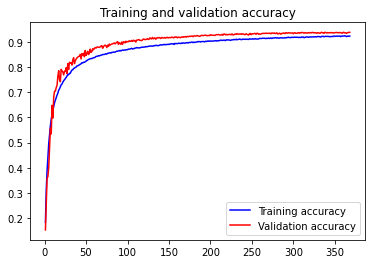

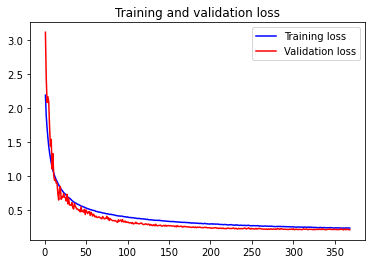

In [8]:
def plot_function(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

plot_function(history)

In [11]:
test_model = keras.models.load_model("models/1_CNN_Model_10_Categories.h5")
test_loss, test_acc = test_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

469/469 [==============================] - 3s 5ms/step - loss: 0.2185 - accuracy: 0.9333
Test accuracy: 0.933


In [12]:
l=os.listdir('Data/')
li=[x.split('.')[0] for x in l]

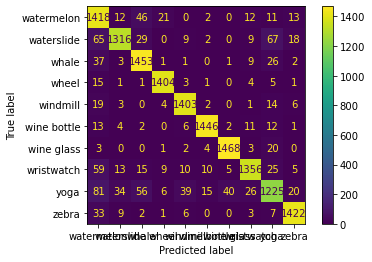

In [13]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = test_model.predict(X_test) 
y_pred = (predictions >= 0.5)
rounded_labels=np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(rounded_labels, y_pred.argmax(axis=1))
matrix.diagonal()/matrix.sum(axis=1)
cmd = ConfusionMatrixDisplay(matrix, display_labels=li)
cmd.plot()